In [1]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from msfm.utils import files, cross_statistics, scales
from msi.utils import input_output

In [2]:
# import os, h5py
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
# import healpy as hp

# from scipy.signal import savgol_filter
# from tqdm import tqdm

# from deepsphere.healpy_layers import HealpySmoothing
# from msfm.utils import tfrecords, files, parameters, scales, power_spectra, cross_statistics
# from msfm.fiducial_pipeline import FiducialPipeline
# from msfm.utils.input_output import read_yaml

# from msi.utils import preprocessing, plotting, input_output

# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

In [3]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# 246pt in inches (for the Phys Rev template)
half_linewidth = 3.41
# 510pt in inches (figure* environment in the Phys Rev template)
full_linewidth = 7.06

In [5]:
conf = "/Users/arne/git/multiprobe-simulation-forward-model/configs/v11/extended.yaml"
conf = files.load_config(conf)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = 8
l_max_global = 3 * n_side - 1
data_vec_pix, _, _, _ = files.load_pixel_file(conf)

24-10-17 09:08:26     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [6]:
file_dict = input_output.load_human_summaries(
    "/Users/arne/data/DESY3/paper_1", "cls", file_label=None, return_raw_cls=True, return_grid=False
)

# only keep the auto bins
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=True,
    with_clustering=True,
    with_cross_z=False,
    with_cross_probe=False,
)
fidu_cls_raw = file_dict["fiducial/cls/raw"][...,bin_indices]

theta_fwhms = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]
l_mins = [None] * n_z
l_maxs = list(scales.angle_to_ell(np.array(theta_fwhms), arcmin=True).astype(int))

fidu_cls = np.zeros_like(fidu_cls_raw)
for i in range(n_z):
    fidu_cls[...,i] = scales.cls_to_smoothed_cls(
        fidu_cls_raw[...,i], 
        l_min=l_mins[i],
        theta_fwhm=None,
        l_max=l_maxs[i],
        arcmin=True
    )

mean_fidu_cls_raw = np.mean(fidu_cls_raw, axis=0)
mean_fidu_cls = np.mean(fidu_cls, axis=0)
print(mean_fidu_cls.shape)

24-10-17 09:08:28 input_output INF   Loading summaries from /Users/arne/data/DESY3/paper_1 
24-10-17 09:08:28 input_output WAR   Returning the raw Cls, this is potentially slow 
24-10-17 09:08:28 input_output INF   Array shapes: 
24-10-17 09:08:28 input_output INF   fiducial/i_example = (2400,) 
24-10-17 09:08:28 input_output INF   fiducial/i_noise   = (2400,) 
24-10-17 09:08:28 input_output INF   fiducial/cls/binned = (2400, 32, 36) 
24-10-17 09:08:28 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-10-17 09:08:28 input_output INF   fiducial/cls/raw   = (2400, 1536, 36) 
24-10-17 09:08:28 input_output INF   Done loading the summaries after 0:00:00.13 
(1536, 8)


In [7]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.01

# i_bin = 7
i_bin = 4
l = np.arange(l_max_global)

# mean
l_max = l_maxs[i_bin]
low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
l_max_noise = l[low_pass_fac_cls < threshold][0]
noise_level_cl = mean_fidu_cls[l_max_noise,i_bin]

sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))

# single example 
original_cls = mean_fidu_cls_raw[:,i_bin]
smoothed_cls = mean_fidu_cls[:,i_bin]

mean_noise_cls = []
mean_noisy_cls = []
for i in tqdm(range(100)):
    noise_map = np.random.normal(0, sigma, n_pix)
    # noise_map = np.zeros(n_pix)
    # noise_map[data_vec_pix] = np.random.normal(0, sigma, data_vec_pix.shape[0])
    noise_cls = hp.anafast(noise_map, lmax=l_max_global)
    noisy_cls = smoothed_cls + noise_cls

    mean_noise_cls.append(noise_cls)
    mean_noisy_cls.append(noisy_cls)
mean_noise_cls = np.mean(mean_noise_cls, axis=0)
mean_noisy_cls = np.mean(mean_noisy_cls, axis=0)

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


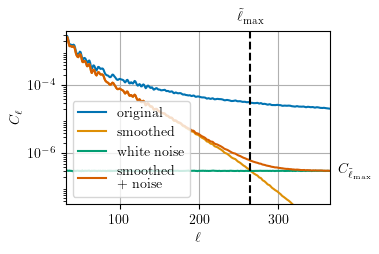

In [41]:
fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth))
# fig, ax = plt.subplots(figsize=(full_linewidth, 0.66*full_linewidth))
colors = sns.color_palette("colorblind")

ax.plot(mean_fidu_cls_raw[:,i_bin], color=colors[0], label="original")
ax.plot(mean_fidu_cls[:,i_bin], color=colors[1], label="smoothed")
ax.plot(mean_noise_cls, color=colors[2], label="white noise")
ax.plot(mean_noisy_cls, color=colors[3], label="smoothed\n+ noise")
ax.axvline(l_max_noise, color="k", linestyle="--")

ax.grid(True)
ax.legend(loc="lower left")
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(32, l_max_noise + 100),
    ylim=(0.1 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
)
ax.text(
    l_max_noise, 
    0.01, 
    r"$\tilde{\ell}_\mathrm{max}$", 
    horizontalalignment="center", 
    verticalalignment="center",
)
ax.text(
    l_max_noise + 130, 
    np.mean(mean_noise_cls), 
    r"$C_{\tilde{\ell}_\mathrm{max}}$", 
    horizontalalignment="center", 
    verticalalignment="center",
)
ax.set_yticks([1e-4, 1e-6])

# fig.tight_layout(pad=0)
# fig.tight_layout()
# ax.set_position([0.15, 0.15, 0.75, 0.75])
# fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

# plt.savefig("plots/smoothing_cls_mean.png", bbox_inches="tight", dpi=300)
plt.savefig("plots/smoothing_cls_mean.pdf", bbox_inches="tight")

# old

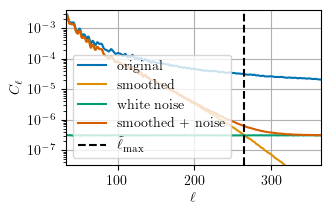

In [15]:
fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth))
colors = sns.color_palette("colorblind")

ax.plot(mean_fidu_cls_raw[:,i_bin], color=colors[0], label="original")
ax.plot(mean_fidu_cls[:,i_bin], color=colors[1], label="smoothed")
ax.plot(mean_noise_cls, color=colors[2], label="white noise")
ax.plot(mean_noisy_cls, color=colors[3], label="smoothed + noise")
ax.axvline(l_max_noise, color="k", linestyle="--", label=r"$\tilde{\ell}_\mathrm{max}$")

ax.grid(True)
ax.legend(loc="lower left")
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(32, l_max_noise + 100),
    ylim=(0.1 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
)
fig.tight_layout()
plt.savefig("plots/smoothing_cls_mean_alternative.pdf", bbox_inches="tight")

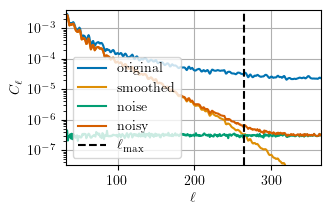

In [14]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.01

# i_bin = 7
i_bin = 4
l = np.arange(l_max_global)

fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth))
# fig, ax = plt.subplots(figsize=(full_linewidth, 0.66*full_linewidth))

colors = sns.color_palette("colorblind")

# mean
l_max = l_maxs[i_bin]
low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
l_max_noise = l[low_pass_fac_cls < threshold][0]
noise_level_cl = mean_fidu_cls[l_max_noise,i_bin]

sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))

# single example 
i_example = 0
original_cls = fidu_cls_raw[i_example,:,i_bin]
smoothed_cls = fidu_cls[i_example,:,i_bin]

noise_map = np.random.normal(0, sigma, n_pix)
# noise_map = np.zeros(n_pix)
# noise_map[data_vec_pix] = np.random.normal(0, sigma, data_vec_pix.shape[0])
noise_cls = hp.anafast(noise_map, lmax=l_max_global)
noisy_cls = smoothed_cls + noise_cls

ax.plot(fidu_cls_raw[i_example,:,i_bin], color=colors[0], label="original")
ax.plot(fidu_cls[i_example,:,i_bin], color=colors[1], label="smoothed")
ax.plot(noise_cls, color=colors[2], label="noise")
ax.plot(noisy_cls, color=colors[3], label="noisy")
ax.axvline(l_max_noise, color="k", linestyle="--", label=r"$\ell_\mathrm{max}$")

ax.grid(True)
ax.legend(loc="lower left")
ax.set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(32, l_max_noise + 100),
    ylim=(0.1 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
)

fig.tight_layout()
plt.savefig("plots/smoothing_cls_single_example.pdf", bbox_inches="tight")

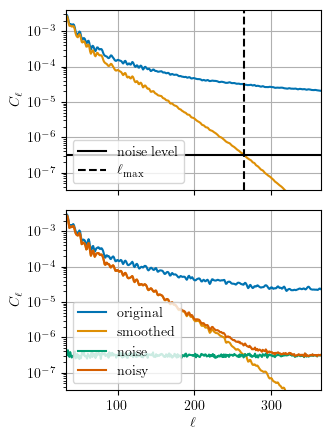

In [15]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.01

# i_bin = 7
i_bin = 4
l = np.arange(l_max_global)

fig, ax = plt.subplots(figsize=(half_linewidth, 2*0.66*half_linewidth), nrows=2, sharex=True, sharey=True)
# fig, ax = plt.subplots(figsize=(full_linewidth, 0.66*full_linewidth))

colors = sns.color_palette("colorblind")

# mean
l_max = l_maxs[i_bin]
low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
l_max_noise = l[low_pass_fac_cls < threshold][0]
noise_level_cl = mean_fidu_cls[l_max_noise,i_bin]

sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))

ax[0].plot(mean_fidu_cls_raw[:,i_bin], color=colors[0])
ax[0].plot(mean_fidu_cls[:,i_bin], color=colors[1])
ax[0].axhline(noise_level_cl, color="k", linestyle="-", label="noise level")
ax[0].axvline(l_max_noise, color="k", linestyle="--", label=r"$\ell_\mathrm{max}$")

ax[0].set(
    ylabel=r"$C_\ell$", 
    xscale="linear", 
    yscale="log", 
    xlim=(32, l_max_noise + 100),
    ylim=(0.1 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
)
ax[0].grid(True)
ax[0].legend(loc="lower left")

# single example 
i_example = 0
original_cls = fidu_cls_raw[i_example,:,i_bin]
smoothed_cls = fidu_cls[i_example,:,i_bin]

noise_map = np.random.normal(0, sigma, n_pix)
noise_cls = hp.anafast(noise_map, lmax=l_max_global)
noisy_cls = smoothed_cls + noise_cls

ax[1].plot(fidu_cls_raw[i_example,:,i_bin], color=colors[0], label="original")
ax[1].plot(fidu_cls[i_example,:,i_bin], color=colors[1], label="smoothed")
ax[1].plot(noise_cls, color=colors[2], label="noise")
ax[1].plot(noisy_cls, color=colors[3], label="noisy")

ax[1].grid(True)
ax[1].legend(loc="lower left")
ax[1].set(
    xlabel=r"$\ell$", 
    ylabel=r"$C_\ell$", 
)

fig.tight_layout()
# plt.savefig("plots/placeholder_smoothing_cls.pdf", bbox_inches="tight")

# old

IndexError: index 99 is out of bounds for axis 1 with size 8

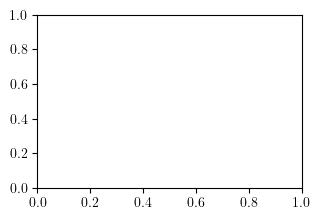

In [16]:
# # the noise level is determined to be equal to the value for which the Cl are suppressed this much
# # threshold = 0.1
# threshold = 0.01

# # i_bin = 7
# i_bin = 4
# l = np.arange(l_max_global)

# fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth))
# # fig, ax = plt.subplots(figsize=(full_linewidth, 0.66*full_linewidth))

# # mean
# l_max = l_maxs[i_bin]
# low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
# l_max_noise = l[low_pass_fac_cls < threshold][0]
# noise_level_cl = mean_fidu_cls[l_max_noise,i]

# sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))

# ax.plot(mean_fidu_cls_raw[:,i_bin], label="original")
# ax.plot(mean_fidu_cls[:,i_bin], label="smoothed")
# ax.axhline(noise_level_cl, color="k", linestyle="-", label="noise level")
# ax.axvline(l_max_noise, color="k", linestyle="--", label=r"$\ell_\mathrm{max}$")
    
# ax.set(
#     xscale="linear", 
#     yscale="log", 
#     # title=f"bin {i_bin}, l_max (naive) = {l_max}, l_max (noise) = {l_max_noise}", 
#     xlabel=r"$\ell$", 
#     ylabel=r"$C_\ell$", 
#     xlim=(32, l_max_noise + 100),
#     ylim=(0.5 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
# )
# ax.grid(True)
# ax.legend(loc="lower left")

# # single example 
# # noise_map = np.random.normal(0, sigma, n_pix)
# # noise_cls = hp.anafast(noise_map, lmax=l_max_global)

# # ax.plot(noise_cls, label="smoothed data")
# # ax.axhline(noise_level_cl, color="k", linestyle="--", label=r"$C_{\ell, \mathrm{noise}}$")

    
# fig.tight_layout()
# plt.savefig("plots/placeholder_smoothing_cls.pdf", bbox_inches="tight")

IndexError: index 99 is out of bounds for axis 1 with size 8

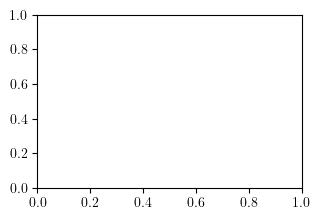

In [17]:
# # the noise level is determined to be equal to the value for which the Cl are suppressed this much
# # threshold = 0.1
# threshold = 0.01

# # i_bin = 7
# i_bin = 4
# l = np.arange(l_max_global)

# fig, ax = plt.subplots(figsize=(half_linewidth, 0.66*half_linewidth))
# # fig, ax = plt.subplots(figsize=(full_linewidth, 0.66*full_linewidth))

# l_max = l_maxs[i_bin]
# low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
# l_max_noise = l[low_pass_fac_cls < threshold][0]
# noise_level_cl = mean_fidu_cls[l_max_noise,i]

# sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
# # noise_map = np.random.normal(0, sigma, n_pix)
# # noise_cls = hp.anafast(noise_map, lmax=l_max_global)

# ax.plot(mean_fidu_cls_raw[:,i_bin], label="original")
# ax.plot(mean_fidu_cls[:,i_bin], label="smoothed")
# # ax.plot(noise_cls, label="smoothed data")
# # ax.axhline(noise_level_cl, color="k", linestyle="--", label=r"$C_{\ell, \mathrm{noise}}$")
# ax.axhline(noise_level_cl, color="k", linestyle="-", label="noise level")
# ax.axvline(l_max_noise, color="k", linestyle="--", label=r"$\ell_\mathrm{max}$")
    
# ax.set(
#     xscale="linear", 
#     yscale="log", 
#     # title=f"bin {i_bin}, l_max (naive) = {l_max}, l_max (noise) = {l_max_noise}", 
#     xlabel=r"$\ell$", 
#     ylabel=r"$C_\ell$", 
#     xlim=(32, l_max_noise + 100),
#     ylim=(0.5 * mean_fidu_cls[32:l_max_noise,i_bin].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i_bin].max()),
# )
# ax.grid(True)
# ax.legend(loc="lower left")
    
# fig.tight_layout()
# plt.savefig("plots/placeholder_smoothing_cls.pdf", bbox_inches="tight")

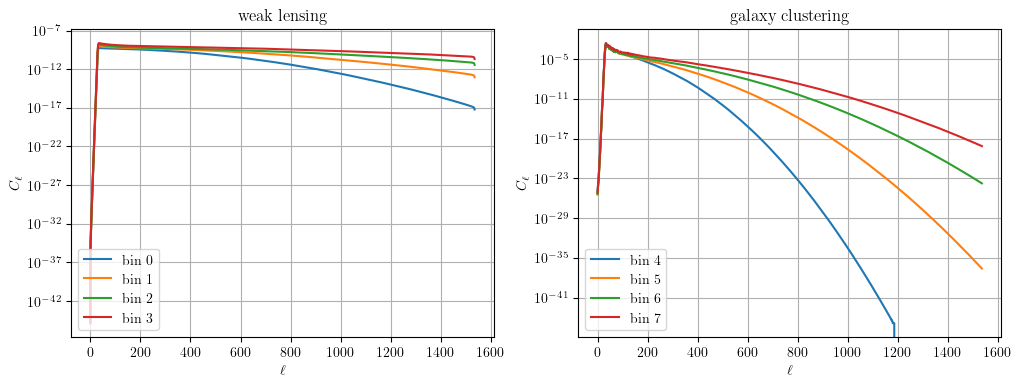

In [18]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)

for i in range(4):
    ax[0].plot(mean_fidu_cls[:,i], label=f"bin {i}")
    
ax[0].set(xscale="linear", yscale="log", title="weak lensing", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
ax[0].grid(True)
ax[0].legend(loc="lower left")
    
for i in range(4,8):
    ax[1].plot(mean_fidu_cls[:,i], label=f"bin {i}")
    
ax[1].set(xscale="linear", yscale="log", title="galaxy clustering", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
ax[1].grid(True)
ax[1].legend(loc="lower left")

# percentage criterion

With a threshold of 0.01, the smoothed cls are 100.62937 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.31843 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 83.27362 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 22.6053 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.316795 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.55537 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.3677 times smaller than the raw ones
With a threshold of 0.01, the smoothed cls are 100.7198 times smaller than the raw ones
[0.00107751 0.00119864 0.00137192 0.00327441 0.27714203 0.14761599
 0.12608089 0.13623727]
[4.6380313e-12 5.7394029e-12 7.5187807e-12 4.2830586e-11 3.0682693e-07
 8.7047340e-08 6.3501972e-08 7.4144779e-08]


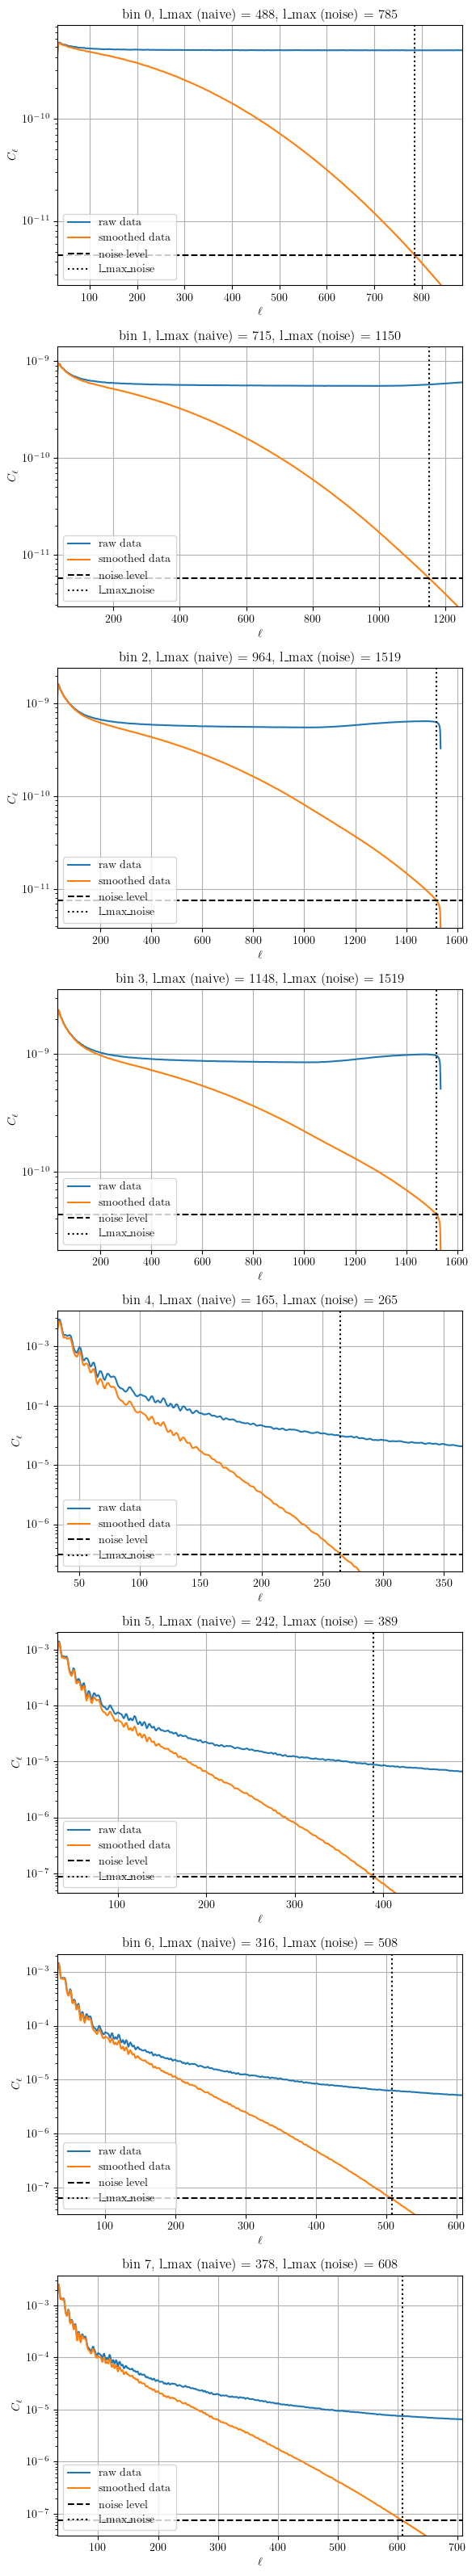

In [19]:
# the noise level is determined to be equal to the value for which the Cl are suppressed this much
# threshold = 0.1
threshold = 0.01
l = np.arange(l_max_global)

fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=False, sharey=False)

sigmas_percent = []
noises_percent = []
for i in range(n_z):
    l_max = l_maxs[i]
    
    # this only works for monotonously decaying functions (which the smoothed Cls are)
    low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, l_max)**2
    try:
        l_max_noise = l[low_pass_fac_cls < threshold][0]
    except IndexError:
        l_max_noise = l_max_global - 16
                        
    print(
        f"With a threshold of {threshold}, the smoothed cls are", 
        mean_fidu_cls_raw[l_max_noise,i]/mean_fidu_cls[l_max_noise,i], 
        "times smaller than the raw ones"
    )

    noise_level_cl = mean_fidu_cls[l_max_noise,i]
    noises_percent.append(noise_level_cl)
    
    sigma = np.sqrt(noise_level_cl / hp.nside2pixarea(n_side))
    sigmas_percent.append(sigma)
    
    ax[i].plot(mean_fidu_cls_raw[:,i], label="raw data")
    ax[i].plot(mean_fidu_cls[:,i], label="smoothed data")
    ax[i].axhline(noise_level_cl, color="k", linestyle="--", label="noise level")
    ax[i].axvline(l_max_noise, color="k", linestyle=":", label="l_max_noise")
        
    ax[i].set(
        xscale="linear", 
        yscale="log", 
        title=f"bin {i}, l_max (naive) = {l_max}, l_max (noise) = {l_max_noise}", 
        xlabel=r"$\ell$", 
        ylabel=r"$C_\ell$", 
        xlim=(32, l_max_noise + 100),
        ylim=(0.5 * mean_fidu_cls[32:l_max_noise,i].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i].max()),
    )
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
fig.tight_layout()

sigmas_percent = np.array(sigmas_percent)
noises_percent = np.array(noises_percent)
print(sigmas_percent)
print(noises_percent)